In [1]:
import torch
from torch import nn

import model_predict

In [2]:
series, scaler = model_predict.read_data_series(scale=True, file_index=2)

时间序列不连贯，缺失的月份： ['2013-11', '2014-12', '2015-04', '2017-12']
即将填充缺失的月份
月份平均：
月份
1     165.417333
2     107.969333
3      95.301778
4     123.181000
5     154.631111
6     202.507111
7     136.807500
8     117.749000
9     157.433000
10    156.723500
11    156.563429
12    136.816000
Name: 销量（箱）, dtype: float64


In [3]:
# 4.1 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out

    def init_weights(self):
        # 遍历 LSTM 层的参数，对参数进行初始化
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.1)  # 使用正态分布初始化权重
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # 将偏置项初始化为零
                
model_parameters = {
    "input_size": 3, "hidden_size": 32, "num_layers": 1, "output_size": 1
}

In [4]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(LSTMModel, model_parameters, series, test_size=24, epochs=500)

训练 LSTMModel 模型
结果保存到： LSTMModel_best.pth
Epoch [50/500], Learn Rate: 1.0000e-03, Training Loss: 0.5574, Validation Loss: 1.1658
Epoch [100/500], Learn Rate: 1.0000e-03, Training Loss: 0.0612, Validation Loss: 1.1586
Epoch [150/500], Learn Rate: 1.0000e-03, Training Loss: 0.0109, Validation Loss: 1.0443
Epoch [200/500], Learn Rate: 1.0000e-03, Training Loss: 0.0024, Validation Loss: 1.0212
Epoch [250/500], Learn Rate: 1.0000e-03, Training Loss: 0.0005, Validation Loss: 1.0400
Epoch [300/500], Learn Rate: 2.5000e-04, Training Loss: 0.0002, Validation Loss: 1.0426
Epoch [350/500], Learn Rate: 2.5000e-04, Training Loss: 0.0002, Validation Loss: 1.0471
Epoch [400/500], Learn Rate: 2.5000e-04, Training Loss: 0.0001, Validation Loss: 1.0516
Epoch [450/500], Learn Rate: 2.5000e-04, Training Loss: 0.0000, Validation Loss: 1.0556
Epoch [500/500], Learn Rate: 2.5000e-04, Training Loss: 0.0000, Validation Loss: 1.0590
Best Validation Loss: 1.0211876034736633


从2018年6月开始后续数据推理
MSE: 12454.68
MAE: 86.03
R^2: -0.67
MAPE: 2.83


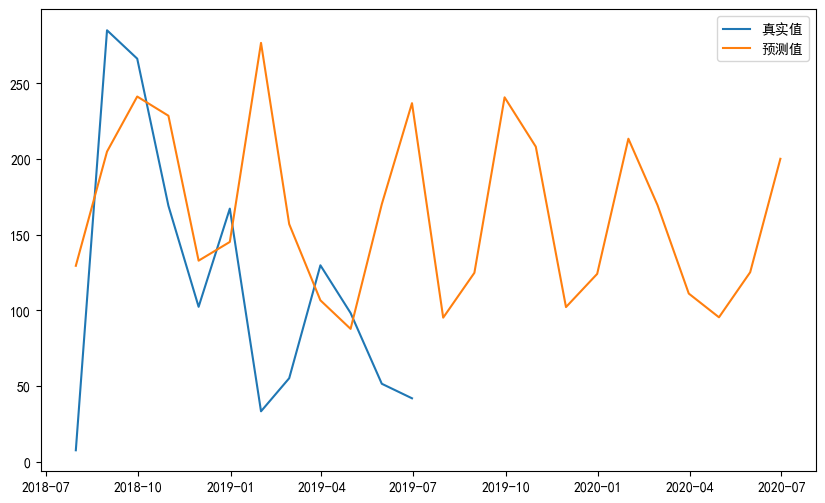

2018-07-31    129.438179
2018-08-31    204.963728
2018-09-30    241.366584
2018-10-31    228.657358
2018-11-30    132.840632
2018-12-31    145.216894
2019-01-31    276.833992
2019-02-28    156.987677
2019-03-31    106.619672
2019-04-30     87.726634
2019-05-31    170.178450
2019-06-30    236.975418
2019-07-31     95.151758
2019-08-31    124.810786
2019-09-30    240.833308
2019-10-31    208.197140
2019-11-30    102.134525
2019-12-31    124.102148
2020-01-31    213.463452
2020-02-29    169.454211
2020-03-31    111.077674
2020-04-30     95.389056
2020-05-31    125.166124
2020-06-30    200.189744
Freq: M, dtype: float64

In [5]:
model = model_predict.load_rnn_model_best(LSTMModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler)